# Titanic Survival Prediction 

This project builds a complete machine learning pipeline to classify whether a passenger survived, using demographic and ticket-related features.

Key objectives:

Perform data cleaning & preprocessing

Engineer meaningful features (Titles, Family Size, Deck, Fare bins)

Train multiple models (Logistic Regression, Decision Tree, Random Forest)

Tune hyperparameters using GridSearchCV

Build a SHAP explainability dashboard to interpret model predictions

| Column Name     | Description                                                                                |
| --------------- | ------------------------------------------------------------------------------------------ |
| **PassengerId** | Unique ID assigned to each passenger.                                                      |
| **Survived**    | Target variable (0 = Did not survive, 1 = Survived).                                       |
| **Pclass**      | Passenger class (1 = Upper, 2 = Middle, 3 = Lower). Represents socio-economic status.      |
| **Name**        | Full passenger name (contains title: Mr, Mrs, Miss, etc.).                                 |
| **Sex**         | Gender of passenger (male/female).                                                         |
| **Age**         | Age of passenger in years (fractional ages possible, e.g., 0.42). Contains missing values. |
| **SibSp**       | Number of siblings or spouses on board.                                                    |
| **Parch**       | Number of parents or children on board.                                                    |
| **Ticket**      | Ticket number (string, often non-uniform format).                                          |
| **Fare**        | Ticket fare (in British Pounds).                                                           |
| **Cabin**       | Cabin number(s). Many missing values; useful for extracting deck.                          |
| **Embarked**    | Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton.                       |


# IMPORTS

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import shap



ModuleNotFoundError: No module named 'streamlit'

# Load Dataset

In [31]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Quick EDA

In [32]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


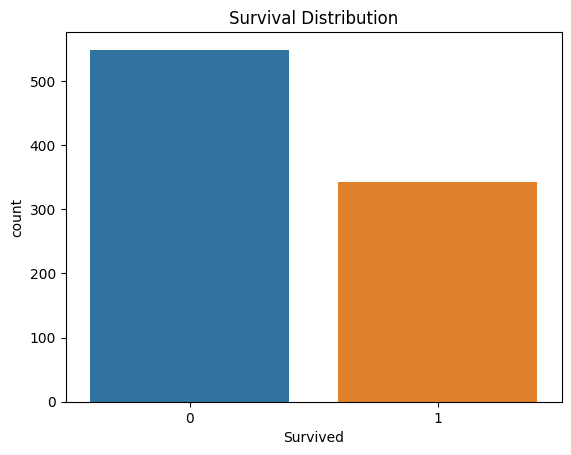

In [33]:
sns.countplot(data=train, x='Survived')
plt.title('Survival Distribution')
plt.show()

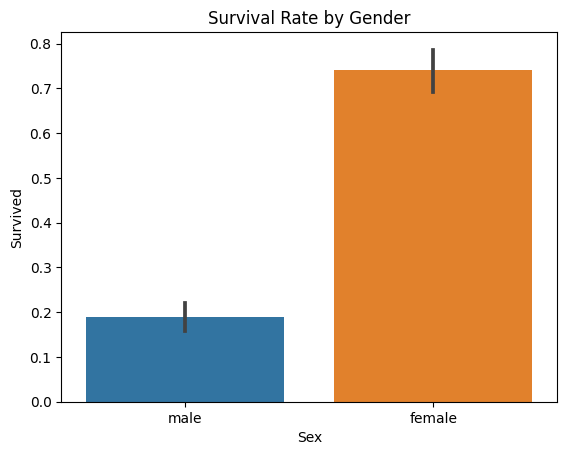

In [34]:
sns.barplot(data=train,x='Sex',y='Survived')
plt.title('Survival Rate by Gender')
plt.show()

# Feature Enginnering

In [35]:
# Extract titles and Simplify it
train["Title"] = train["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)


In [36]:
title_map = {
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
    "Lady": "Royal", "Countess": "Royal", "Sir": "Royal", "Jonkheer": "Royal",
    "Dona": "Royal"
}
train["Title"] = train["Title"].replace(title_map)

In [37]:
# Family size
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

In [38]:
# Deck Extraction
train['Deck'] = train['Cabin'].str[0]
train['Deck'] = train['Deck'].fillna('Unknown')

In [39]:
#Fill missing values
train['Age'].fillna(train['Age'].median(),inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)
train['Fare'].fillna(train['Fare'].median(),inplace=True)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A valu

In [40]:
cat_cols = ['Sex','Embarked','Title','Deck']
train = pd.get_dummies(train, columns = cat_cols,drop_first = True)

In [41]:
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title_Rev,Title_Royal,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,...,False,False,False,False,False,False,False,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,...,False,False,False,True,False,False,False,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,False,False,False,False,False,False,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,...,False,False,False,True,False,False,False,False,False,False
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,...,False,False,False,False,False,False,False,False,False,True


In [42]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'FamilySize', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Title_Col', 'Title_Don', 'Title_Dr', 'Title_Major',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev',
       'Title_Royal', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_Unknown'],
      dtype='object')

In [43]:
train.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)


# Train - Test Splits

In [44]:
X = train.drop("Survived", axis=1)
y = train["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
# Scale numerical values (for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# Train Models

## Logistic Regression

In [46]:
log_reg = LogisticRegression(max_iter=300)
log_reg.fit(X_train_scaled, y_train)
lr_pred = log_reg.predict(X_test_scaled)
print("LR Accuracy:", accuracy_score(y_test, lr_pred))


LR Accuracy: 0.8212290502793296


## Decision Tree

In [47]:
dt = DecisionTreeClassifier(max_depth = 5, random_state=42)
dt.fit(X_train,y_train)
dt_pred = dt.predict(X_test)
print("Dt Accuracy: ", accuracy_score(y_test,dt_pred))


Dt Accuracy:  0.8212290502793296


## Random Forest

In [49]:
rf = RandomForestClassifier(
    n_estimators = 300,
    max_depth = 6,
    random_state = 42
    
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("RF Accuracy: ", accuracy_score(y_test, rf_pred))



RF Accuracy:  0.8324022346368715


# Hyperparameter Tuning

In [53]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=5, scoring="accuracy")

grid.fit(X_train, y_train)

print("Best RF:", grid.best_params_)
best_rf = grid.best_estimator_


Best RF: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 200}


# Evaluation

Accuracy: 0.8379888268156425

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86       105
           1       0.82      0.78      0.80        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



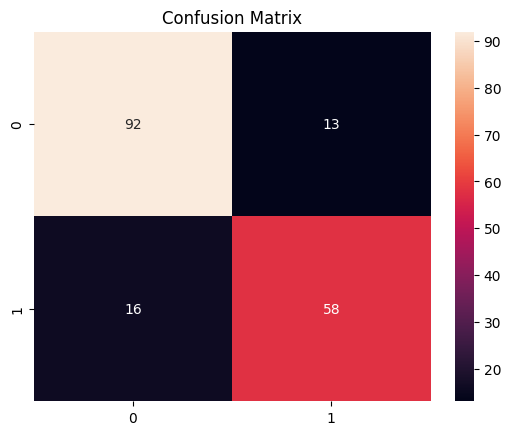

In [54]:
pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred))

sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


# SHAP Interpretability

In [55]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)


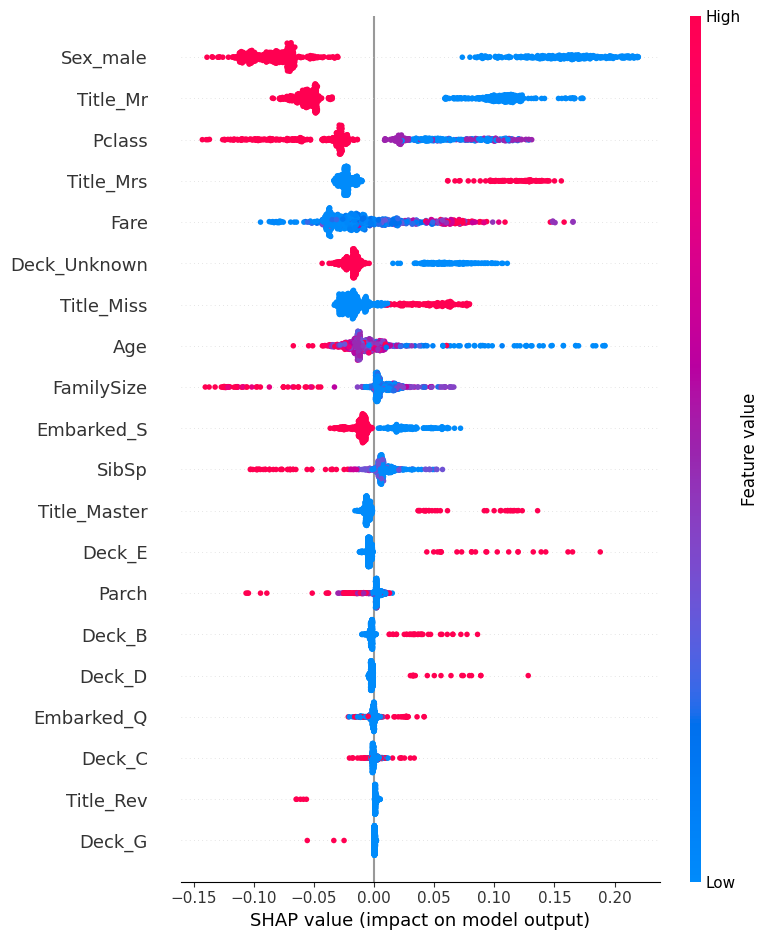

In [56]:
shap.summary_plot(shap_values[1], X_train)   # class 1 (Survived)

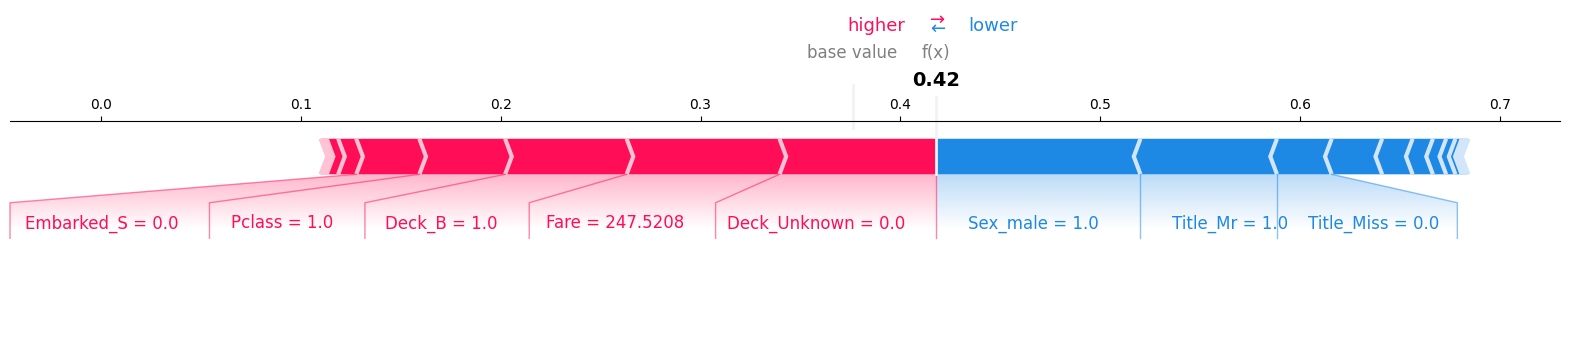

In [57]:
# Local Explanation for One Passenger
idx = 5  # pick any passenger from test
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][idx],
    X_train.iloc[idx],
    matplotlib=True
)
